## Script that creates a montage of 500 images of gems, ranked by hue left to right

Import the regular libraries

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.color      import rgb2hsv
from skimage.transform  import rescale, resize, downscale_local_mean
from skimage.util       import montage
import math                                                            

Define a function that will a) remove the background and b) calculate the mean value. The background is taken as the average values of the top 5 rows of the images, then these values are subtracted from each channel and all pixels that are on average 5 values away (15 for the three channels) are removed. 

In [2]:
def image_mean_no_background(im) :
    # reshape image into a 3 column array
    im=im[:,:,0:3]
    #print(im.shape)
    im2 = im.reshape(im.shape[0]*im.shape[1],3)
    #print(im2.shape)
    #calculate the background as the mean from the top 5 rows
    background_r = im[1:5,:,0].mean()
    background_g = im[1:5,:,1].mean()
    background_b = im[1:5,:,2].mean()
    # remove the background, for that subtract the means from each channel
    # those points that are +-5 values away from the means are not background
    
    im3 = im2[( abs(im2[:,0]-background_r)+abs(im2[:,1]-background_g)+abs(im2[:,2]-background_g))>15,:]

    #calculate mean of the image without the background
    im_mean_rgb =([ im3[:,0].mean() , im3[:,1].mean() , im3[:,2].mean()])
    return im_mean_rgb


Test with two different images, lapis lazuli (dark blue) and amber (bright yellow)

[91.92980687727658, 98.6194359808481, 142.32867517353554]

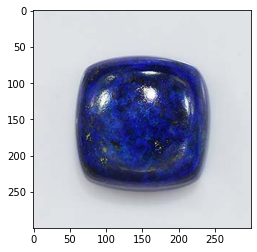

In [4]:
im = imageio.imread('test_selected/Lapis Lazuli/lapis lazuli_3.jpg')
plt.imshow(im)
image_mean_no_background(im)

[194.8785778142541, 138.07530080752716, 59.19525742675831]

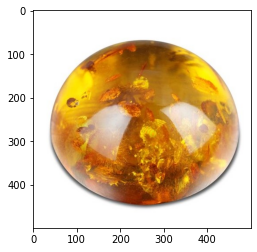

In [5]:
im = imageio.imread('test_selected/Amber/amber_9.jpg')
plt.imshow(im)
image_mean_no_background(im)

Define the base folders and the number of files in each

In [7]:
test_folders          = os.listdir('test_selected')
train_folders         = os.listdir('train_selected')

In [8]:
numTestFolders        = len(test_folders)
numTrainFolders       = len(train_folders)

Determine the total number of files in the nested folders

In [10]:
number_files = 0 
for count_1 in train_folders :
    # first loop over the folders
    current_folder = os.listdir('train_selected/'+count_1)
    #print(current_folder)    
    #second loop over the files in the folder
    for count_2 in current_folder :
        number_files = number_files + 1 
        #im = imageio.imread('train/'+count_1+ '/' +count_2)
        #print(count_2)
        #print(image_mean_no_background(im))
        #average_rgb[count_names,0:3]= image_mean_no_background(im)
        
print(number_files)    



2042


1. Read all files, 
2. calculate central RGB, 
3. Convert to HSV
4. resize to 128x128 and save in a 4D array [rows,cols,3,numimages]

In [11]:
average_rgb = np.zeros((number_files,3))
average_hsv = np.zeros((number_files,3))
all_Images  = np.zeros((128,128,3,number_files))


count_names = 0
for count_1 in train_folders :
    # first loop over the folders
    current_folder = os.listdir('train_selected/'+count_1)
    #print(current_folder)    
    #second loop over the files in the folder
    for count_2 in current_folder :

        im = imageio.imread('train_selected/'+count_1+ '/' +count_2)
        #print(count_2)
        #print(image_mean_no_background(im))
        tempValue                    = image_mean_no_background(im)
        average_rgb[count_names,0:3] = tempValue
        average_hsv[count_names,0:3] = rgb2hsv(np.array(tempValue))
        all_Images[:,:,:,count_names]= resize(im[:,:,0:3], (128, 128),
                       anti_aliasing=True)
        count_names                  = count_names + 1 



Sort the hue, but keep the index of the ranked hue

In [12]:
index_hue = np.argsort(average_hsv[:,0])
index_hue

array([1234, 1242, 1051, ...,  580,  976, 1368])

Create a function that arranges a certain number of images in the format [rows,cols,3,n] into a montage of [r*rows,c*cols,3]

In [13]:
def image_montage(images,side_dimensions=(3,3)) :
    # determine the dimensions
    #r,c,l,nm = all_Images[:,:,:,0:9].shape
    r,c,l,nm = images.shape
    
    #determine dimensions 
    if side_dimensions[0]==side_dimensions[1] :
        # for cases where rows = cols
        side_r = math.ceil(np.sqrt(nm))
        side_c = math.ceil(np.sqrt(nm))    
        new_image = np.zeros((r*side_r,c*side_c,3))
        for count in range(nm) :
            new_r = r*math.floor(count/side_r)
            new_c = c*(count%side_c)
            #print(new_r,new_c)
            new_image[new_r:new_r+r,new_c:new_c+c,:]=images[:,:,:,count]
    else :
        # for cases where the sides are not equal
        side_r = side_dimensions[0]
        side_c = side_dimensions[1]
        #new image
        new_image = np.zeros((r*side_r,c*side_c,3))
        #print(new_image.shape)
        count = 0
        for count_c in range(side_c) :
            for count_r in range(side_r) :
                new_r = r*count_r
                new_c = c*count_c
                #print(new_r,new_c)
                if count<nm :
                    #only process if there are still images in the montage
                    new_image[new_r:new_r+r,new_c:new_c+c,:]=images[:,:,:,count]
                    count=count+1
        
    return new_image
    

Test with the first 9 images

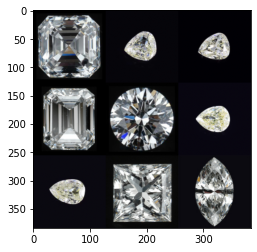

In [14]:
qq=image_montage(all_Images[:,:,:,0:9])
plt.imshow(qq)

Create a montage of 500 images, in 10 rows and 50 columns indexed by hue left to right

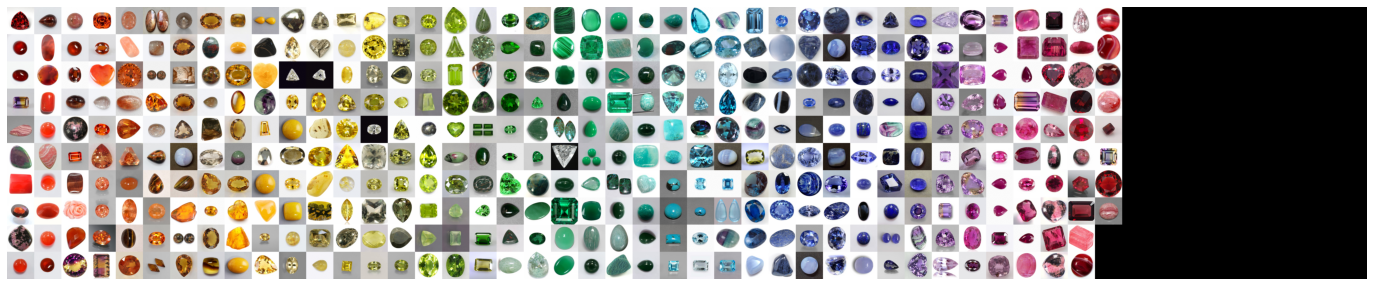

In [15]:
qq = image_montage(all_Images[:,:,:,index_hue[2:2850:5]],(10,50))


fig   = plt.figure(figsize = (25, 5))
ax    = fig.add_subplot(111)
plt.imshow(qq)
plt.axis('off')
plt.savefig('Fig_1_montage.png', dpi=300,bbox_inches='tight', pad_inches=0)